___AE2___

___Task 1___

Loading Data

Sample colors (Enter in 1 by 1 and in this format please): 
0,150,0
0,0,45
125,0,0

In [180]:
#Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import math
import networkx as nx
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.metrics.pairwise import euclidean_distances



In [181]:
#Getting a list of colors from user
bob = []
while True:  
    RGB = input("Enter some colors in rgb format: ")
    bob.append(RGB)
    cont = input("Do you want to add more colors (Y/N)")
    if cont == "N":
        break
#Loading the dataset
color_df = pd.read_csv("colour_naming_data.csv", header = 4)
#color_df = pd.DataFrame(read)
color_df

,sample_id,colour_name,R,G,B
0,24,dark khaki,77,72,52
1,64,dark brown,77,38,28
2,202,Pale greyish blue,111,120,164
3,236,pale pink,212,160,187
4,308,light green,112,163,70
...,...,...,...,...,...
4995,329,pink,189,130,175
4996,379,red violet,125,33,99
4997,507,red blue,133,0,124
4998,551,red violet,178,120,244


Cleaning Data

In [182]:
#Cleaning the dataset
color_df['colour_name'] = color_df['colour_name'].str.lower() #Lowercases all words
color_df['colour_name'] = color_df['colour_name'].str.replace('-', ' ') #Replaces "-" with a space

In [183]:
color_df

,sample_id,colour_name,R,G,B
0,24,dark khaki,77,72,52
1,64,dark brown,77,38,28
2,202,pale greyish blue,111,120,164
3,236,pale pink,212,160,187
4,308,light green,112,163,70
...,...,...,...,...,...
4995,329,pink,189,130,175
4996,379,red violet,125,33,99
4997,507,red blue,133,0,124
4998,551,red violet,178,120,244


In [184]:
#Combine duplicate RGB values and rename the remaining row with the most common color name for that RGB set
unique_color_df = color_df.groupby(['R', 'G', 'B'])['colour_name'].agg(lambda x: x.mode().iat[0]).reset_index()

In [185]:
unique_color_df

,R,G,B,colour_name
0,0,0,0,black
1,0,28,66,navy blue
2,0,49,103,dark blue
3,0,55,66,bluegreen
4,0,56,59,bluegreen
...,...,...,...,...
595,255,189,41,yellow
596,255,216,255,pink
597,255,226,146,yellow
598,255,228,80,yellow


Training a model with a training and test set

In [186]:
#Leave-One-Out Cross Validation

# Extract features (RGB values) and target labels (colour_name)
X = unique_color_df[['R', 'G', 'B']]  # Features (RGB values)
y = unique_color_df['colour_name']     # Target labels

#LeaveOneOut: Cross-Validator
loo = LeaveOneOut()

def training(k):
    '''
    
    :param k: How many neighbors
    :prints: Overall accuracy for k neighbors
    '''
    knn = KNeighborsClassifier(n_neighbors=k)
    
    predictions = []
    actual_labels = []
    
    for train_index, test_index in loo.split(unique_color_df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        #Train the classifier
        knn.fit(X_train, y_train)
    
        #Make Predictions
        predicted = knn.predict(X_test)
        predictions.extend(predicted)
        actual_labels.extend(y_test)
    
    overall_accuracy = accuracy_score(actual_labels, predictions)
    
    print(f"Overall accuracy (neighbors = {k}): {overall_accuracy:.2f}")
    
    
    unique_color_df['predicted_colors'] = predictions
    
    #Run the code below if you wish to see the accuracy for each individual color.
    '''for color in unique_color_df['colour_name'].unique():
        color_mask = unique_color_df['colour_name'] == color
        color_accuracy = accuracy_score(unique_color_df[color_mask]['colour_name'], unique_color_df[color_mask]['predicted_colors'])
        print(f"Accuracy for {color}: {color_accuracy:.2f}")'''

In [187]:
#Running the training set for neighbors 1-12
for x in range(1, 13):
    training(x)

Overall accuracy (neighbors = 1): 0.36
Overall accuracy (neighbors = 2): 0.34
Overall accuracy (neighbors = 3): 0.37
Overall accuracy (neighbors = 4): 0.40
Overall accuracy (neighbors = 5): 0.40
Overall accuracy (neighbors = 6): 0.41
Overall accuracy (neighbors = 7): 0.42
Overall accuracy (neighbors = 8): 0.43
Overall accuracy (neighbors = 9): 0.43
Overall accuracy (neighbors = 10): 0.44
Overall accuracy (neighbors = 11): 0.45
Overall accuracy (neighbors = 12): 0.44


In [188]:
unique_color_df

,R,G,B,colour_name,predicted_colors
0,0,0,0,black,black
1,0,28,66,navy blue,dark blue
2,0,49,103,dark blue,blue
3,0,55,66,bluegreen,dark green
4,0,56,59,bluegreen,dark green
...,...,...,...,...,...
595,255,189,41,yellow,yellow
596,255,216,255,pink,white
597,255,226,146,yellow,peach
598,255,228,80,yellow,yellow


Training a model without a training or test set

In [189]:
X = unique_color_df[['R', 'G', 'B']]  #RGB values
y = unique_color_df['colour_name']    #Color Names

#Perform stratified n-fold cross-validation
stratified_kfold = StratifiedKFold()
def training1(x):
    '''    
    :param x: number of n-folds
    :prints: The cv-scores and the average accuracy
    '''
    knn = KNeighborsClassifier(n_neighbors=x)
    
    cv = cross_val_score(knn, X, y, cv=stratified_kfold)
    
    #Print cross-validation scores
    print(f"{x} n-folds")
    print("Cross-validation scores:", cv)
    print("Mean accuracy:", cv.mean())

While running the next two blocks of code I get the error message: "The least populated class in y has only 1 members, which is less than n_splits=5". While the code still works for me, I recognize that this is not ideal, however when I fix the error another error occurs and in the end I could not find a solution to this problem.

In [190]:
#Run the model for classifiers performance from 1-12
for x in range(1, 13):
    training1(x)

1 n-folds
Cross-validation scores: [0.2        0.31666667 0.40833333 0.325      0.19166667]
Mean accuracy: 0.28833333333333333
2 n-folds
Cross-validation scores: [0.16666667 0.25833333 0.28333333 0.3        0.16666667]
Mean accuracy: 0.23500000000000001
3 n-folds
Cross-validation scores: [0.20833333 0.30833333 0.36666667 0.375      0.19166667]
Mean accuracy: 0.29
4 n-folds
Cross-validation scores: [0.26666667 0.35       0.45833333 0.35833333 0.21666667]
Mean accuracy: 0.32999999999999996


C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_select

5 n-folds
Cross-validation scores: [0.25833333 0.36666667 0.46666667 0.36666667 0.24166667]
Mean accuracy: 0.34
6 n-folds
Cross-validation scores: [0.25       0.40833333 0.475      0.41666667 0.25833333]
Mean accuracy: 0.3616666666666667
7 n-folds
Cross-validation scores: [0.28333333 0.40833333 0.48333333 0.39166667 0.26666667]
Mean accuracy: 0.36666666666666664
8 n-folds
Cross-validation scores: [0.3        0.40833333 0.5        0.41666667 0.28333333]
Mean accuracy: 0.38166666666666665
9 n-folds
Cross-validation scores: [0.30833333 0.41666667 0.525      0.44166667 0.3       ]
Mean accuracy: 0.3983333333333333
10 n-folds
Cross-validation scores: [0.3        0.40833333 0.5        0.41666667 0.3       ]
Mean accuracy: 0.385
11 n-folds
Cross-validation scores: [0.30833333 0.4        0.5        0.425      0.28333333]
Mean accuracy: 0.3833333333333334


C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_select

12 n-folds
Cross-validation scores: [0.325      0.425      0.49166667 0.43333333 0.28333333]
Mean accuracy: 0.3916666666666667


Classification report

In [191]:
#Empty lists to store the performance metrics
accuracy = []
precision = []
recall = []
f1 = []

#Define k values to test
k = range(1, 13)

#Perform a stratified n-fold cross-validation
cv_fold = StratifiedKFold()


for n in k:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    #Cross-validation prediction
    predict = cross_val_predict(knn, X, y, cv=cv_fold)

    #Get the performance metrics
    accuracy.append(accuracy_score(y, predict))
    report = classification_report(y, predict, output_dict=True, zero_division=0)
    precision.append(report['weighted avg']['precision'])
    recall.append(report['weighted avg']['recall'])
    f1.append(report['weighted avg']['f1-score'])

#Print performance report
print("Performance Report:")
print("K Value\tAccuracy\tPrecision\tRecall\t\tF1 score")
for i, h in enumerate(k):
    print(f"{h}\t\t{accuracy[i]:.4f}\t\t{precision[i]:.4f}\t\t{recall[i]:.4f}\t\t{f1[i]:.4f}")

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_select

Performance Report:
K Value	Accuracy	Precision	Recall		F1 score
1		0.2883		0.3196		0.2883		0.2979
2		0.2350		0.2980		0.2350		0.2540
3		0.2900		0.3071		0.2900		0.2931
4		0.3300		0.3150		0.3300		0.3181
5		0.3400		0.2942		0.3400		0.3124
6		0.3617		0.2942		0.3617		0.3213
7		0.3667		0.2836		0.3667		0.3164
8		0.3817		0.2800		0.3817		0.3186
9		0.3983		0.2842		0.3983		0.3273
10		0.3850		0.2722		0.3850		0.3143
11		0.3833		0.2650		0.3833		0.3083
12		0.3917		0.2639		0.3917		0.3102


C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

C:\Users\max\anaconda3\envs\AE2\lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



Accuracy is the ratio of correct predictions (true positives and true negatives) to the total number of instances in the dataset. It provides an overall measure of how often the classifier is correct. Precision is the ratio of correct positive predictions (true positives) to the total number of positive observations (true positives and false positives). It measures the ability of the classifier not to label a negative sample as positive. Recall is the ratio of correct positive predictions (true positives) to the total actual positive observations (true positives and false negatives). It measures the ability of the classifier to find all positive samples. The F1 score is the mean of precision and recall.

In general the higher the k-value the higher the accuracy and recall. Precision and F1-score however seem to fluctuate heavenly without regard to the k-value. This means the ratio of correct predictions to total colors and the ratio of true positives to actual positives increase with k-value. On the other hand the ratio of true positives to total positive observations has no obvious pattern with regard to the k-value. As a result since Precision has no obvious pattern, and the F1-score is directly correlated with Precision, the F1-score also has no obvious pattern with regard to the k-value.

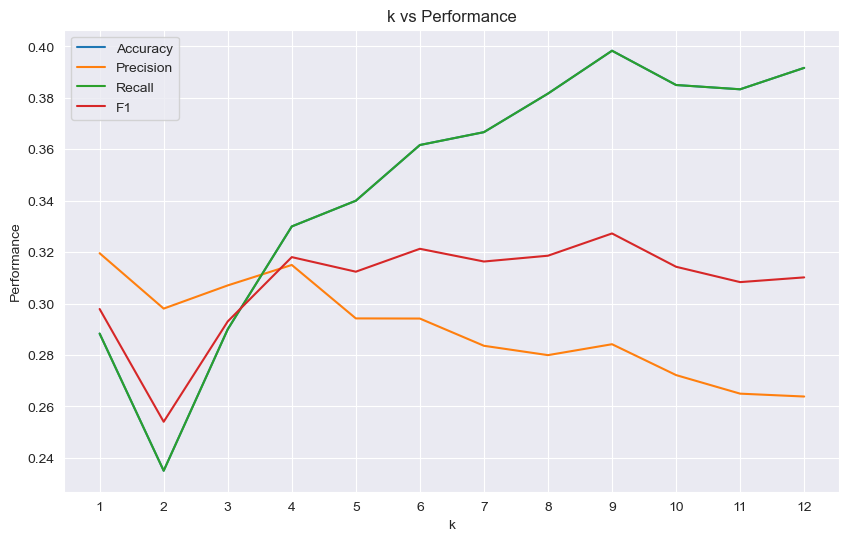

In [192]:
import matplotlib.pyplot as plt
#Line Plot
plt.figure(figsize=(10, 6))

# Line plots for performance metrics vs. k values
plt.plot(k, accuracy, label = 'Accuracy')
plt.plot(k, precision, label = 'Precision')
plt.plot(k, recall, label = 'Recall')
plt.plot(k, f1, label = 'F1')

plt.title('k vs Performance')
plt.xlabel('k')
plt.ylabel('Performance')
plt.legend()
plt.xticks(k)
plt.show()

Accuracy has the same values as Recall so the Recall line covers the Accuracy line. This means that the  ratio of correct predictions to the total number of colors is the same as the ratio between the number of correct positive predictions to the total actual positive observations. In other words the model's correctness is the same as it's ability to predict positive samples.

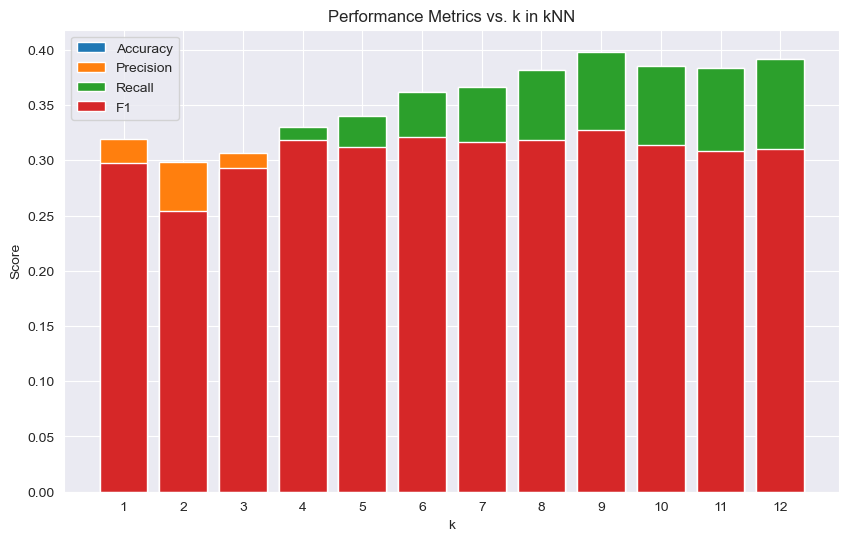

In [193]:
#Bar graph
plt.figure(figsize=(10, 6))

plt.bar(k, accuracy, label = 'Accuracy')
plt.bar(k, precision, label = 'Precision')
plt.bar(k, recall, label = 'Recall')
plt.bar(k, f1, label = 'F1')

plt.title('Performance Metrics vs. k in kNN')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.xticks(k)
plt.show()

This bar graph doesn't show all the categories because some are hidden behind others. For example, since Accuracy and Recall have the same values, Accuracy is always behind Recall. In addition, as seen in the line graph above, Precision dips after k = 3 so it is also covered while Recall is covered by Precision when k < 4.

In [194]:
#Dictionary for the test points given at the beginning
bob1 = {'R':[], 'G':[], 'B':[]}
for x in bob:
    add = x.strip('[]').split(',')
    bob1['R'].append(add[0])
    bob1['G'].append(add[1])
    bob1['B'].append(add[2])
print(bob1)

{'R': ['0'], 'G': ['50'], 'B': ['89']}


In [195]:
#Create a DataFrame from the dictionary
color_test_df = pd.DataFrame.from_dict(bob1)
color_test_df

,R,G,B
0,0,50,89


In [196]:
#Get the predicted color of each test RGB color via the model
test = color_test_df[['R', 'G', 'B']]
pred_colors = knn.predict(test)

color_test_df['Predicted Color'] = pred_colors

print(color_test_df)

   R   G   B Predicted Color
0  0  50  89       dark blue


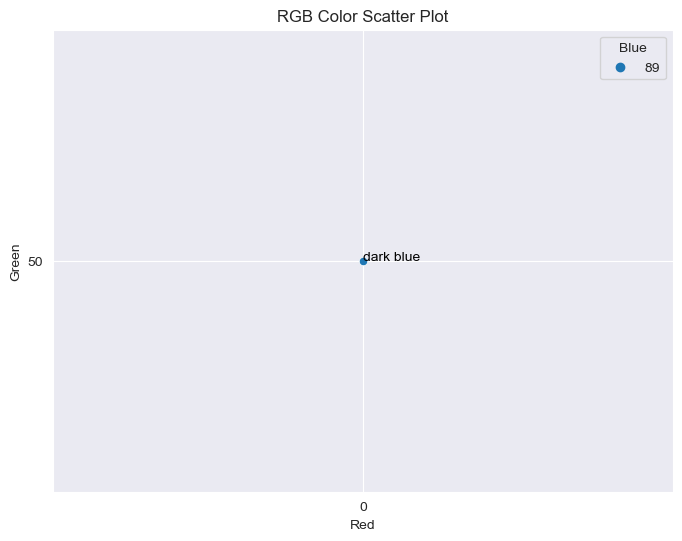

In [197]:
#Plot the predicted colors
#X axis is the Red, Y axis is the Green, and the Hue is blue
plt.figure(figsize=(8, 6))
sns.scatterplot(x = color_test_df['R'], y = color_test_df['G'], hue =color_test_df['B'])

for i in range(len(color_test_df)):
    plt.text(color_test_df['R'][i], color_test_df['G'][i], str(color_test_df['Predicted Color'][i]), fontsize=10, color='black')

plt.xlabel('Red')
plt.ylabel('Green')
plt.title('RGB Color Scatter Plot')
plt.legend(title = 'Blue')
plt.grid(True)
plt.show()

___Task 2___

Ten sample colors (Enter in 1 by 1): 
[255,0,0]
[0,255,0]
[0, 0, 255]
[255, 255, 0]
[255, 0, 255]
[0, 255, 255]
[128, 0, 0]
[0, 128, 0]
[0, 0, 128]
[128, 128, 128]

In [198]:
#Creates an empty list to store RGB values
Alice = []
#Ask the user for 10 colors
for x in range(10):
    c_i = input("Enter a color in RGB format: ")
    #Split the string and change it to a list of integers
    c_i_split = c_i.strip('[]').split(',')
    #Empty list for integer RGB values
    c_i_list = []
    for num in c_i_split:
        c_i_list.append(int(num))
    Alice.append(c_i_list)

In [199]:
print(Alice)

[[155, 0, 0], [0, 255, 0], [0, 2, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255], [128, 0, 0], [0, 128, 0], [0, 0, 128], [128, 128, 128]]


In [200]:
#Distance between test colors
def distance(point1, point2):
    ''' 
    param point1: RGB color1
    param point2: RGB color2
    return: distance between the two colors
    '''
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

#Empty list to record all the distances
distance_list = []
for i in range(len(Alice)):
    for j in range(len(Alice)):
        if i != j and j > i:
            distance_list.append(distance(Alice[i], Alice[j]))
            
print(distance_list)

[298.41246622753545, 298.4191682851489, 273.9069184960467, 392.5238846235984, 273.9069184960467, 27.0, 201.0198995124612, 201.0198995124612, 183.0218566182739, 359.21302871694394, 255.0, 255.0, 441.6729559300637, 285.3226244096321, 127.0, 285.3226244096321, 221.12666053644458, 440.5212821192638, 253.0, 255.00784301664135, 285.3296339324046, 284.43101096751036, 127.01574705523721, 219.97499857938402, 360.62445840513925, 360.62445840513925, 284.8754113643366, 284.8754113643366, 382.666957026603, 220.54931421339762, 360.62445840513925, 382.666957026603, 284.8754113643366, 284.8754113643366, 220.54931421339762, 284.8754113643366, 382.666957026603, 284.8754113643366, 220.54931421339762, 181.01933598375618, 181.01933598375618, 181.01933598375618, 181.01933598375618, 181.01933598375618, 181.01933598375618]


The above code and list of number does not show the distance between the test colors and centroids of the predicted names, only between the test colors. The distance between the colors and predicted names will be shown further below.

In [201]:
#Dictionary to store individual values of Red, Green, and Blue
Alice1 = {'R':[], 'G':[], 'B':[]}
for x in Alice:
    Alice1['R'].append(x[0])
    Alice1['G'].append(x[1])
    Alice1['B'].append(x[2])

In [202]:
#Convert the dictionary to a DataFrame
color_pred_df = pd.DataFrame.from_dict(Alice1)
color_pred_df

,R,G,B
0,155,0,0
1,0,255,0
2,0,2,255
3,255,255,0
4,0,255,255
5,255,0,255
6,128,0,0
7,0,128,0
8,0,0,128
9,128,128,128


In [203]:
#Get the predicted color of each set of RGB values
test = color_pred_df[['R', 'G', 'B']]
pred_colors = knn.predict(test)

color_pred_df['Predicted Color'] = pred_colors

print(color_pred_df)

     R    G    B Predicted Color
0  155    0    0             red
1    0  255    0           green
2    0    2  255            blue
3  255  255    0          yellow
4    0  255  255            blue
5  255    0  255            pink
6  128    0    0           brown
7    0  128    0           green
8    0    0  128       dark blue
9  128  128  128            grey


In [204]:
#Find the Euclidian distance from the test values given by the user and the centroid values of the dataset

#Empty list to store RGB values and distance of each color
R_list = []
G_list = []
B_list = []
Distance = []

#Get the centroids of each color from the dataset
centroids = unique_color_df.groupby('colour_name')[['R', 'G', 'B']].mean().reset_index()

#For each color in the test color list
for index, row in color_pred_df.iterrows():
    for index1, row1 in centroids.iterrows():
        #Match the test color with the centroid
        if row['Predicted Color'] == row1['colour_name']:
            #Add the centroid color RGB values to the RGB lists
            R_list.append(row1['R'])
            G_list.append(row1['G'])
            B_list.append(row1['B'])
            #Get the distance from the test color to the centroid
            Distance.append(math.sqrt((row['R'] - row1['R']) ** 2 + (row['G'] - row1['G']) ** 2 + (row['B'] - row1['B']) ** 2))
            break
    
#Add the centroid RGB values and distance to the previous dictionary
Alice1['Average R'] = R_list
Alice1['Average G'] = G_list
Alice1['Average B'] = B_list
Alice1['Distance'] = Distance

#Convert the dictionary to a DataFrame again
color_pred_df = pd.DataFrame.from_dict(Alice1)
color_pred_df['Predicted Color'] = pred_colors
color_pred_df

,R,G,B,Average R,Average G,Average B,Distance,Predicted Color
0,155,0,0,194.125000,23.750000,46.000000,64.890894,red
1,0,255,0,87.452381,154.095238,87.642857,159.721509,green
2,0,2,255,73.178571,113.857143,184.482143,151.128726,blue
3,255,255,0,221.722222,201.000000,73.166667,96.833732,yellow
4,0,255,255,73.178571,113.857143,184.482143,173.922907,blue
5,255,0,255,223.925926,108.574074,176.277778,137.663052,pink
6,128,0,0,108.387097,65.709677,38.903226,78.840907,brown
7,0,128,0,87.452381,154.095238,87.642857,126.531225,green
8,0,0,128,28.400000,37.400000,82.500000,65.387843,dark blue
9,128,128,128,124.333333,123.800000,131.133333,6.395485,grey


Text(0.5, 1.0, 'Predicted Color vs RGB Value Distance')

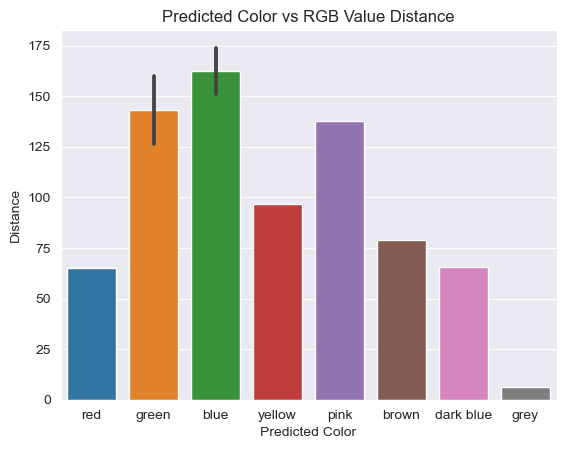

In [205]:
#Create a barplot
sns.barplot(data = color_pred_df, x = 'Predicted Color', y = 'Distance', hue_order = 'Predicted Color')
plt.title("Predicted Color vs RGB Value Distance")

In [206]:
#Create a graph
G = nx.Graph()

#Add nodes to the graph
for idx, row in centroids.iterrows():
    G.add_node(row['colour_name'], R = row['R'], G = row['G'], B = row['B'])

In [207]:
#Calculate distance between centroids and add weighted edges
centroids_values = centroids[['R', 'G', 'B']].values
num_centroids = len(centroids)

In [208]:
#Calculate distance between centroids
distances = np.zeros((num_centroids, num_centroids))
for i in range(num_centroids):
    for j in range(i+1, num_centroids):
        dist = np.linalg.norm(centroids_values[i] - centroids_values[j])
        distances[i, j] = dist
        distances[j, i] = dist

In [209]:
#Add weighted edges to the graph
for i, node1 in centroids.iterrows():
    for j, node2 in centroids.iterrows():
        if i != j:
            G.add_edge(node1['colour_name'], node2['colour_name'], weight = distances[i, j])

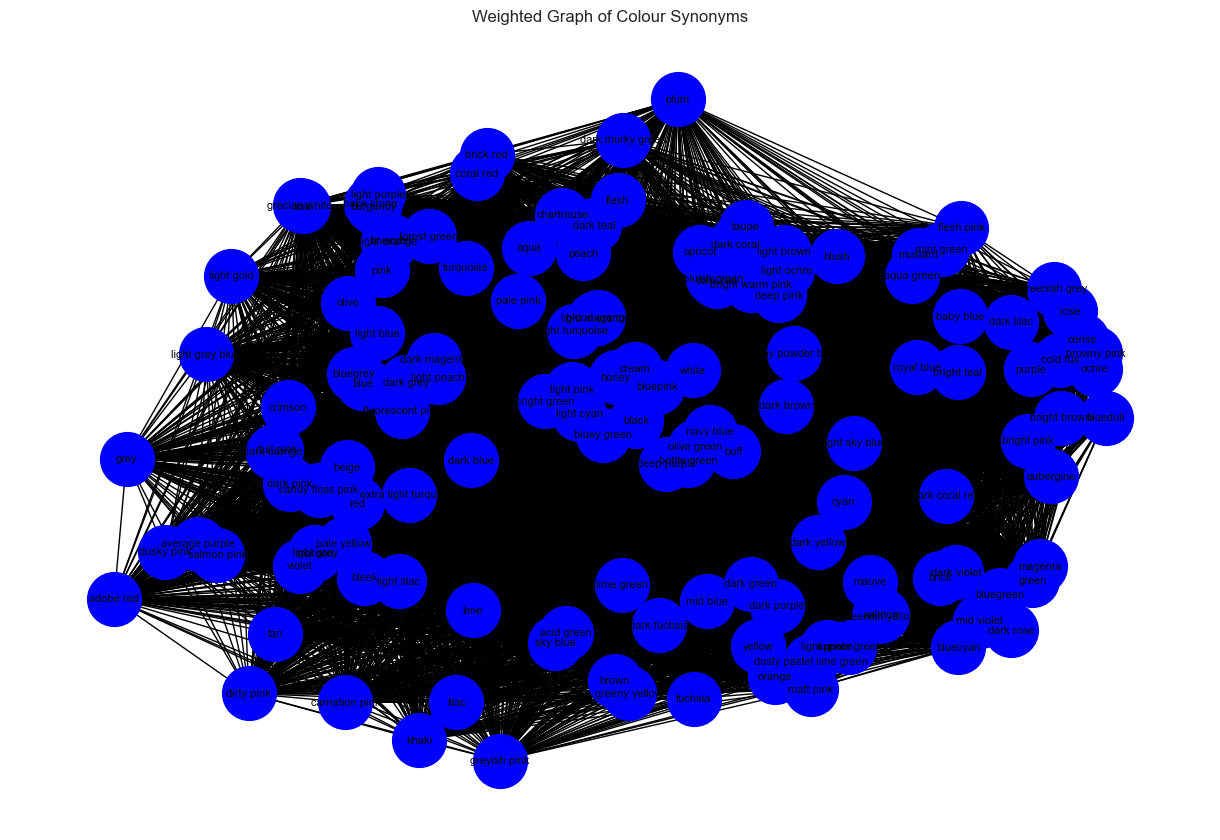

In [210]:
#Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, scale = 1.5) # Position nodes using spring layout algorithm
nx.draw(G, pos, with_labels = True, node_color = 'blue', node_size = 1500, font_size = 8)

#The code below replaces the edge's with the numerical value of the edge's weight. Run if interested
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)

plt.title('Weighted Graph of Colour Synonyms')
plt.show()

__Task 3__

Reflection

During the coding of this project, I really struggled in creating a kNN model with a n-fold cross validation without a test or training set. In class, we only learned how to create a Leave-One-Out model with a training and testing set so I had to teach myself what a n-fold cross validation was which took a long time. Once I learned though it was pretty simple. All I had to do was change the LeaveOneOut() cross validator function with the StratifiedKFold() function. Then instead of using the train and test set, I used the cross_val_predict() function to train my model. Another problem I had was trying to figure out how to append a DataFrame. Normally I could have just used a .append() method but I think pandas recently updated and now the function is no longer callable. I was really confused for a while but realized what had changed after doing some research. Instead of using the .append() method now, I created dictionaries for the RGB values and converted the dictionaries to DataFrames. The last major issue I had was when I tried running the kNN model and performance report. I would always get the error message "The least populated class in y has only 1 members, which is less than n_splits=5. warnings.warn(" when I tried to run the code. When I adjusted the n_splits value to be 1, I got another error message. This problem still persists even though I spent lots of time trying to figure it out and fix it. Even so, the code still works and creates the model and the performance report so I ultimately decided to just keep it.
  
  I learned a lot in doing this project regarding creating training models and creating plots with those models. Although we learned how to create models in class, through this project I learned another, and maybe more efficient, way of creating training models. I also learned how to make nodes with weighted edges.
  
  If I could improve my code in the future, fixing the error message I received is mainly what I would try to fix. However, there is another part I would also like to improve which is the bar plot for the Predicted color vs RGB value distance. Two things I would like to improve here are first, changing the color of the bars to match the color the bar is representing, and two, having the bar plot show all bars even if they share the same name. Currently, if there are two of the same predicted colors, the bar plot will create a bar for the one with the lowest distance and add a small extension on the top for the second one. I would prefer to create separate bars but didn't have enough time to do so. The last thing I would like to improve is the efficiency of my code. Some parts like the graphs and especially the weighted graph take a long time load which isn't ideal. In the future I would like to experiment with more ways to make the code run faster.